# 01. Drug-Target Interaction Data Exploration

This notebook explores the DAVIS and KIBA datasets for drug-target interaction prediction.

## Contents
1. Load and explore DAVIS dataset
2. Load and explore KIBA dataset
3. Analyze molecular data
4. Analyze protein sequences
5. Visualize interaction matrices
6. Statistical analysis of binding affinities

In [1]:
# Import required libraries
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm

# Chemical informatics
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.Chem.Draw import IPythonConsole

# Set up paths
PROJECT_ROOT = Path('../')
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DATA = DATA_DIR / 'raw'

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load DAVIS Dataset

In [5]:
def load_davis_data():
    """Load DAVIS dataset"""
    davis_dir = RAW_DATA / 'davis'
    
    # Load affinity matrix
    affinity = pickle.load(open(davis_dir / 'Y', 'rb'), encoding='latin1')
    
    # Load drug SMILES (JSON format)
    with open(davis_dir / 'ligands_can.txt', 'r') as f:
        drug_smiles = json.load(f)
    
    # Load target sequences (JSON format)
    with open(davis_dir / 'proteins.txt', 'r') as f:
        target_sequences = json.load(f)
    
    return {
        'affinity': affinity,
        'drug_smiles': drug_smiles,
        'target_sequences': target_sequences
    }


# Load DAVIS data
davis_data = load_davis_data()
print(f"DAVIS Dataset:")
print(f"  - Number of drugs: {len(davis_data['drug_smiles'])}")
print(f"  - Number of targets: {len(davis_data['target_sequences'])}")
print(f"  - Affinity matrix shape: {davis_data['affinity'].shape}")
print(f"  - Total interactions: {np.prod(davis_data['affinity'].shape)}")
print(f"  - Non-zero interactions: {np.sum(davis_data['affinity'] < 30000)}")

DAVIS Dataset:
  - Number of drugs: 68
  - Number of targets: 442
  - Affinity matrix shape: (68, 442)
  - Total interactions: 30056
  - Non-zero interactions: 30056


## 2. Load KIBA Dataset

In [7]:
def load_kiba_data():
    """Load KIBA dataset"""
    kiba_dir = RAW_DATA / 'kiba'
    
    # Load affinity matrix
    affinity = pickle.load(open(kiba_dir / 'Y', 'rb'), encoding='latin1')
    
    # Load drug SMILES (JSON format)
    with open(kiba_dir / 'ligands_can.txt', 'r') as f:
        drug_smiles = json.load(f)
    
    # Load target sequences (JSON format)
    with open(kiba_dir / 'proteins.txt', 'r') as f:
        target_sequences = json.load(f)
    
    return {
        'affinity': affinity,
        'drug_smiles': drug_smiles,
        'target_sequences': target_sequences
    }


# Load KIBA data
kiba_data = load_kiba_data()
print(f"KIBA Dataset:")
print(f"  - Number of drugs: {len(kiba_data['drug_smiles'])}")
print(f"  - Number of targets: {len(kiba_data['target_sequences'])}")
print(f"  - Affinity matrix shape: {kiba_data['affinity'].shape}")
print(f"  - Total interactions: {np.prod(kiba_data['affinity'].shape)}")
print(f"  - Non-zero interactions: {np.sum(~np.isnan(kiba_data['affinity']))}")

KIBA Dataset:
  - Number of drugs: 2111
  - Number of targets: 229
  - Affinity matrix shape: (2111, 229)
  - Total interactions: 483419
  - Non-zero interactions: 118254


## 3. Analyze Molecular data

In [8]:
def analyze_molecules(smiles_dict, dataset_name):
    """Analyze molecular properties"""
    properties = []
    
    for name, smiles in tqdm(list(smiles_dict.items())[:100], desc=f"Analyzing {dataset_name} molecules"):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            properties.append({
                'name': name,
                'smiles': smiles,
                'mol_weight': Descriptors.MolWt(mol),
                'logp': Descriptors.MolLogP(mol),
                'num_atoms': mol.GetNumAtoms(),
                'num_bonds': mol.GetNumBonds(),
                'num_rings': Descriptors.RingCount(mol),
                'num_rotatable_bonds': Descriptors.NumRotatableBonds(mol),
                'tpsa': Descriptors.TPSA(mol)
            })
    
    return pd.DataFrame(properties)

# Analyze DAVIS molecules
davis_mol_props = analyze_molecules(davis_data['drug_smiles'], 'DAVIS')
print("\nDAVIS Molecular Properties:")
print(davis_mol_props.describe())

Analyzing DAVIS molecules:   0%|          | 0/68 [00:00<?, ?it/s]


DAVIS Molecular Properties:
       mol_weight       logp  num_atoms  num_bonds  num_rings  \
count   68.000000  68.000000  68.000000  68.000000  68.000000   
mean   452.846926   4.065158  32.058824  35.441176   4.455882   
std     86.670969   1.497843   6.260233   7.090844   1.226983   
min    277.755000  -0.819500  19.000000  21.000000   3.000000   
25%    379.765250   3.284500  27.000000  30.000000   4.000000   
50%    454.100500   4.304710  31.500000  34.000000   4.000000   
75%    516.318000   5.056075  37.000000  41.000000   5.000000   
max    641.621000   6.931900  46.000000  51.000000   9.000000   

       num_rotatable_bonds        tpsa  
count            68.000000   68.000000  
mean              5.661765   90.910294  
std               2.773060   26.846817  
min               1.000000   39.340000  
25%               3.750000   74.495000  
50%               5.000000   88.510000  
75%               7.000000  102.930000  
max              13.000000  183.120000  


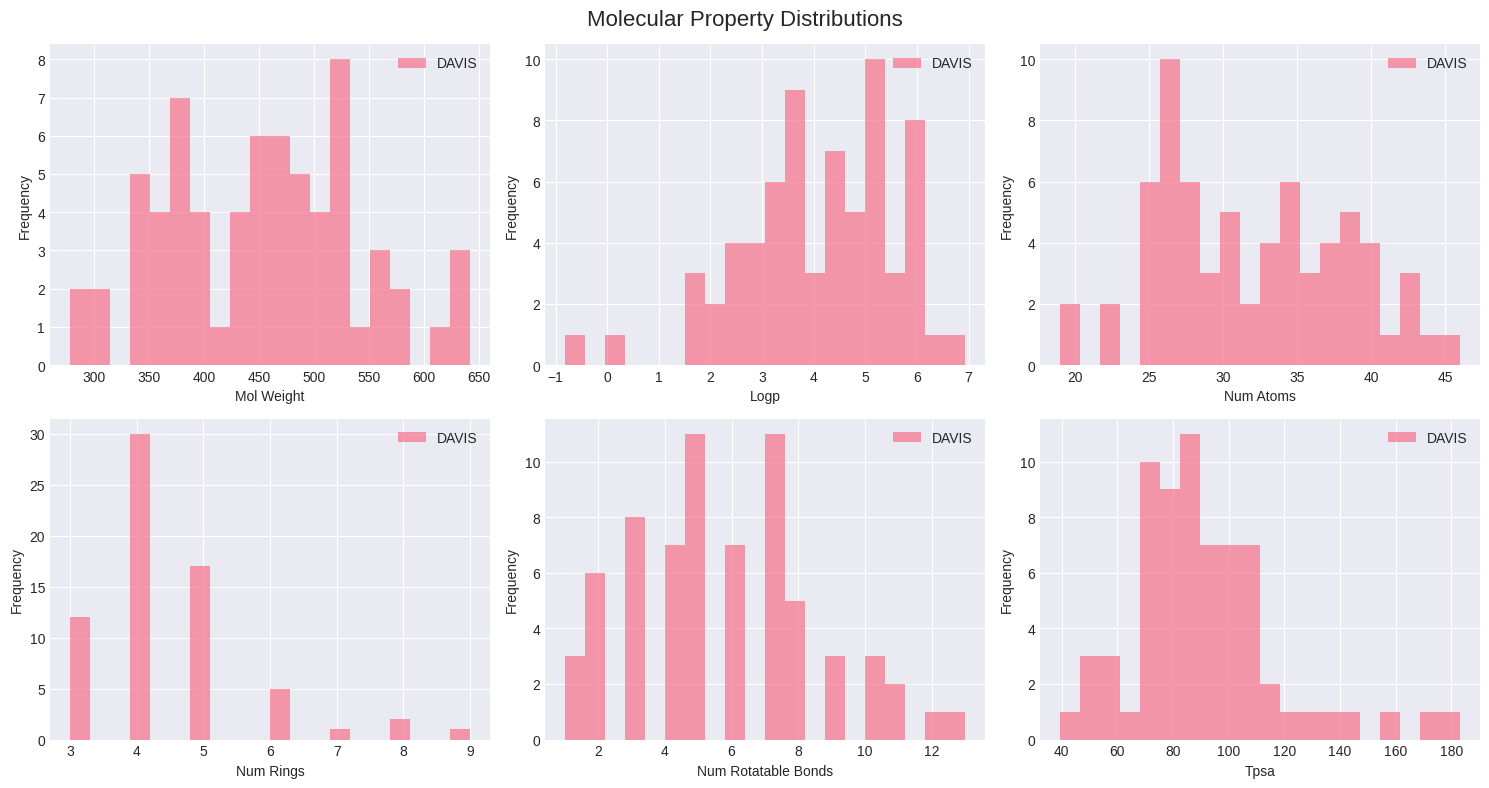

In [9]:
# Visualize molecular property distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
properties_to_plot = ['mol_weight', 'logp', 'num_atoms', 'num_rings', 'num_rotatable_bonds', 'tpsa']

for idx, prop in enumerate(properties_to_plot):
    ax = axes[idx // 3, idx % 3]
    davis_mol_props[prop].hist(ax=ax, bins=20, alpha=0.7, label='DAVIS')
    ax.set_xlabel(prop.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.legend()

plt.suptitle('Molecular Property Distributions', fontsize=16)
plt.tight_layout()
plt.show()

## 4. Visualize Sample Molecules

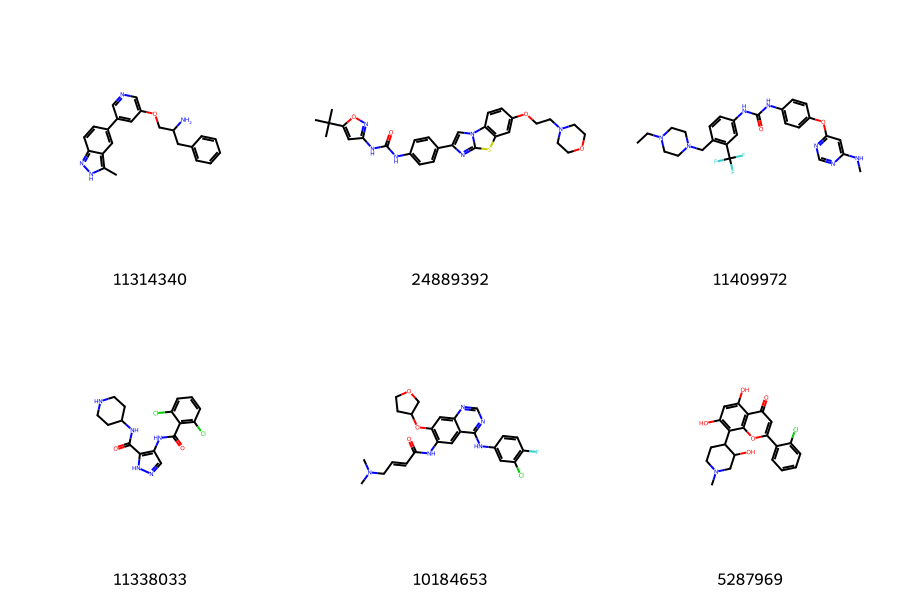

In [10]:
# Display sample molecules
sample_drugs = list(davis_data['drug_smiles'].items())[:6]
mols = [Chem.MolFromSmiles(smiles) for name, smiles in sample_drugs]
legends = [name for name, _ in sample_drugs]

# Create grid image
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), legends=legends)
img

## 5. Analyze Protein Sequences

In [11]:
def analyze_proteins(sequences_dict, dataset_name):
    """Analyze protein sequence properties"""
    properties = []
    
    for name, sequence in sequences_dict.items():
        # Basic sequence properties
        properties.append({
            'name': name,
            'length': len(sequence),
            'num_cysteines': sequence.count('C'),
            'hydrophobic_ratio': sum(1 for aa in sequence if aa in 'AILMFWV') / len(sequence),
            'charged_ratio': sum(1 for aa in sequence if aa in 'DEKR') / len(sequence)
        })
    
    return pd.DataFrame(properties)

# Analyze proteins
davis_prot_props = analyze_proteins(davis_data['target_sequences'], 'DAVIS')
print("DAVIS Protein Properties:")
print(davis_prot_props.describe())

DAVIS Protein Properties:
            length  num_cysteines  hydrophobic_ratio  charged_ratio
count   442.000000     442.000000         442.000000     442.000000
mean    788.947964      17.042986           0.343833       0.245308
std     378.767663      13.076453           0.028104       0.033337
min     244.000000       2.000000           0.245283       0.138843
25%     488.750000       8.000000           0.325099       0.222336
50%     707.000000      12.000000           0.345336       0.244216
75%    1015.000000      23.000000           0.362274       0.263821
max    2549.000000      64.000000           0.410458       0.395233


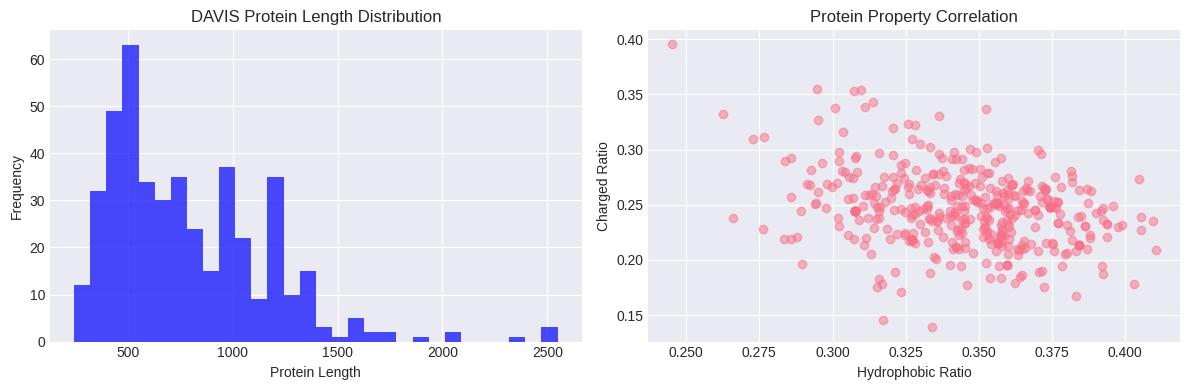

In [12]:
# Visualize protein length distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(davis_prot_props['length'], bins=30, alpha=0.7, color='blue')
ax1.set_xlabel('Protein Length')
ax1.set_ylabel('Frequency')
ax1.set_title('DAVIS Protein Length Distribution')

ax2.scatter(davis_prot_props['hydrophobic_ratio'], 
           davis_prot_props['charged_ratio'], alpha=0.5)
ax2.set_xlabel('Hydrophobic Ratio')
ax2.set_ylabel('Charged Ratio')
ax2.set_title('Protein Property Correlation')

plt.tight_layout()
plt.show()

## 6. Visualize Interaction Matrices

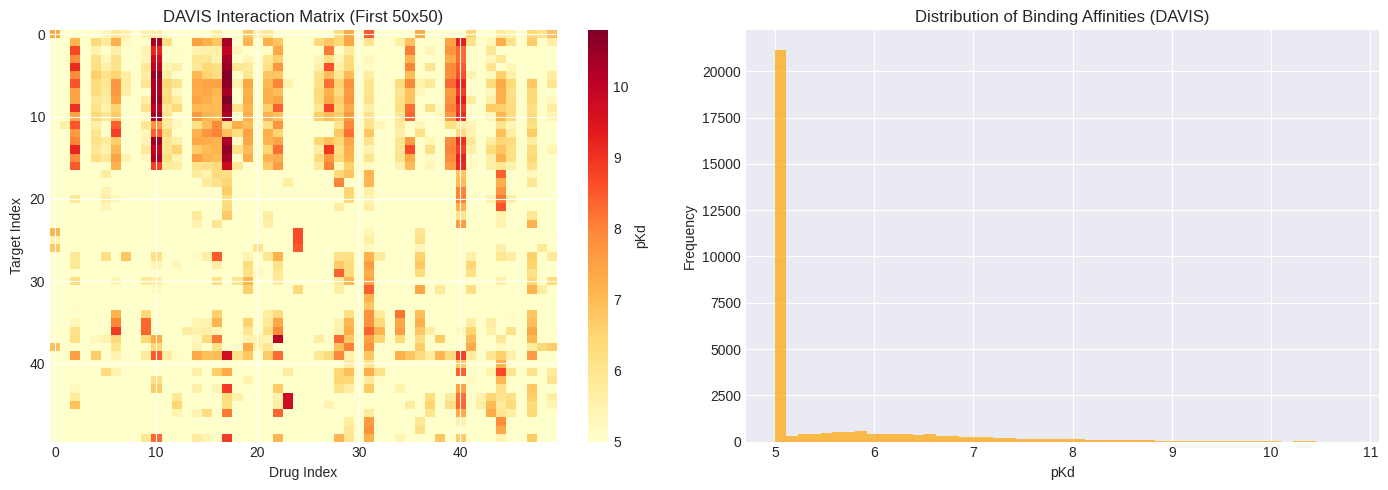

In [ ]:
# Visualize DAVIS interaction matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Full interaction matrix (subset for visibility)
subset_size = 50
davis_subset = davis_data['affinity'][:subset_size, :subset_size].T  # Transpose here

# Convert Kd to pKd for better visualization (higher = stronger binding)
davis_pkd = -np.log10(davis_subset / 1e9)
davis_pkd[davis_subset >= 30000] = 0  # Set non-interactions to 0

im1 = ax1.imshow(davis_pkd, cmap='YlOrRd', aspect='auto')
ax1.set_xlabel('Drug Index')      
ax1.set_ylabel('Target Index')  
ax1.set_title(f'DAVIS Interaction Matrix (First {subset_size}x{subset_size})')
plt.colorbar(im1, ax=ax1, label='pKd')

# Distribution of binding affinities
valid_affinities = davis_data['affinity'][davis_data['affinity'] < 30000]
pkd_values = -np.log10(valid_affinities / 1e9)

ax2.hist(pkd_values, bins=50, alpha=0.7, color='orange')
ax2.set_xlabel('pKd')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Binding Affinities (DAVIS)')

plt.tight_layout()
plt.show()

In [14]:
print(f"Affinity matrix shape: {davis_data['affinity'].shape}")


Affinity matrix shape: (68, 442)


## 7. Statistical Summary

In [17]:
def calculate_dataset_statistics(data, dataset_name):
    """Calculate comprehensive dataset statistics"""
    affinity = data['affinity']
    
    if dataset_name == 'DAVIS':
        valid_mask = affinity < 30000
    else:  # KIBA
        valid_mask = ~np.isnan(affinity)
    
    stats = {
        'Dataset': dataset_name,
        'Num Drugs': len(data['drug_smiles']),
        'Num Targets': len(data['target_sequences']),
        'Total Pairs': np.prod(affinity.shape),
        'Known Interactions': np.sum(valid_mask),
        'Sparsity (%)': (1 - np.sum(valid_mask) / np.prod(affinity.shape)) * 100,
        'Avg Interactions/Drug': np.sum(valid_mask) / len(data['drug_smiles']),
        'Avg Interactions/Target': np.sum(valid_mask) / len(data['target_sequences'])
    }
    
    return stats

# Calculate statistics for both datasets
davis_stats = calculate_dataset_statistics(davis_data, 'DAVIS')
kiba_stats = calculate_dataset_statistics(kiba_data, 'KIBA')

# Create comparison dataframe
stats_df = pd.DataFrame([davis_stats, kiba_stats])
print("\nDataset Comparison:")
print(stats_df.to_string(index=False))


Dataset Comparison:
Dataset  Num Drugs  Num Targets  Total Pairs  Known Interactions  Sparsity (%)  Avg Interactions/Drug  Avg Interactions/Target
  DAVIS         68          442        30056               30056      0.000000             442.000000                68.000000
   KIBA       2111          229       483419              118254     75.537991              56.018001               516.393013


## 8. Data Quality Analysis

In [18]:
def check_data_quality(data, dataset_name):
    """Check for data quality issues"""
    print(f"\n{dataset_name} Data Quality Check:")
    print("="*50)
    
    # Check for invalid SMILES
    invalid_smiles = []
    for name, smiles in data['drug_smiles'].items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            invalid_smiles.append(name)
    
    print(f"✓ Invalid SMILES: {len(invalid_smiles)} / {len(data['drug_smiles'])}")
    
    # Check protein sequences
    valid_amino_acids = set('ACDEFGHIKLMNPQRSTVWY')
    invalid_sequences = []
    
    for name, seq in data['target_sequences'].items():
        if not all(aa in valid_amino_acids for aa in seq):
            invalid_sequences.append(name)
    
    print(f"✓ Invalid protein sequences: {len(invalid_sequences)} / {len(data['target_sequences'])}")
    
    # Check affinity matrix
    if dataset_name == 'DAVIS':
        print(f"✓ Affinity range: {np.min(data['affinity']):.2f} - {np.max(data['affinity']):.2f}")
        print(f"✓ Number of 30000 values (no interaction): {np.sum(data['affinity'] >= 30000)}")
    else:
        valid_affinities = data['affinity'][~np.isnan(data['affinity'])]
        print(f"✓ Valid affinity range: {np.min(valid_affinities):.2f} - {np.max(valid_affinities):.2f}")
        print(f"✓ Number of NaN values: {np.sum(np.isnan(data['affinity']))}")

# Check data quality
check_data_quality(davis_data, 'DAVIS')
check_data_quality(kiba_data, 'KIBA')


DAVIS Data Quality Check:
✓ Invalid SMILES: 0 / 68
✓ Invalid protein sequences: 1 / 442
✓ Affinity range: 0.02 - 10000.00
✓ Number of 30000 values (no interaction): 0

KIBA Data Quality Check:
✓ Invalid SMILES: 0 / 2111
✓ Invalid protein sequences: 0 / 229
✓ Valid affinity range: 0.00 - 17.20
✓ Number of NaN values: 365165


## 9. Save Processed Data Info

In [21]:
# Convert numpy types to JSON-serializable types
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    elif hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# Save dataset information for later use
processed_dir = DATA_DIR / 'processed'
processed_dir.mkdir(exist_ok=True)

dataset_info = {
    'davis': {
        'num_drugs': len(davis_data['drug_smiles']),
        'num_targets': len(davis_data['target_sequences']),
        'stats': convert_numpy_types(davis_stats)
    },
    'kiba': {
        'num_drugs': len(kiba_data['drug_smiles']),
        'num_targets': len(kiba_data['target_sequences']),
        'stats': convert_numpy_types(kiba_stats)
    }
}

with open(processed_dir / 'dataset_info.json', 'w') as f:
    json.dump(dataset_info, f, indent=2)

print("\n Dataset information saved to data/processed/dataset_info.json")



 Dataset information saved to data/processed/dataset_info.json


## Summary

### Key Findings:

1. **DAVIS Dataset**:
   - Focused on kinase proteins
   - Smaller but high-quality dataset
   - Uses Kd values for binding affinity

2. **KIBA Dataset**:
   - Larger dataset with more compounds
   - Combined bioactivity scores
   - More sparse than DAVIS

3. **Molecular Properties**:
   - Drug molecules show diverse chemical properties
   - Most are drug-like (following Lipinski's rule of five)

4. **Protein Targets**:
   - Mainly kinase proteins
   - Wide range of sequence lengths

### Next Steps:
1. Preprocess data and create molecular graphs
2. Generate protein representations
3. Create train/validation/test splits
4. Build GNN models for DTI prediction